In [4]:
import yaml

In [5]:
# load menu
with open("../mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [6]:
if menu['all_stats']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from io import StringIO
    import requests
    from sklearn.preprocessing import MinMaxScaler
    from shapely.geometry import shape
    from shapely.ops import unary_union
    import pint
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import requests
    import re
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import Point
    from fiona.crs import from_epsg
    from nbconvert import MarkdownExporter
    import nbformat
    import base64
    import pickle
    import plotly.graph_objects as go
    import seaborn as sns
    import plotly.express as px
    from datetime import datetime
    import squarify
    import matplotlib.colors as mcolors

In [7]:
url = "https://raw.githubusercontent.com/compoundrisk/monitor/databricks/src/country-groups.csv"
country_groups = pd.read_csv(url)
helpers_url = "https://raw.githubusercontent.com/compoundrisk/monitor/databricks/src/fns/helpers.R"
helpers_code = requests.get(helpers_url).text

def tolatin(x):
    return stri_trans_general(x, id="Latin-ASCII")
def normalize(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)
def print_text(x, linebreaks=2):
    print(x + "\n" + "<br>" * linebreaks)

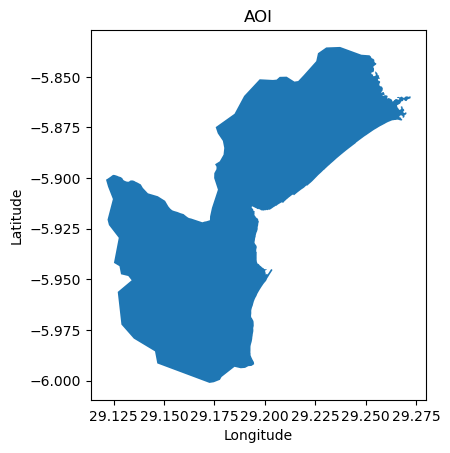

In [8]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("../mnt/city-directories/01-user-input/city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans
with open("../global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(os.path.join('..', city_inputs['AOI_path'])).to_crs(epsg=4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('../mnt/city-directories/02-process-output')
# Define render folder ---------
render_folder = Path('../mnt/city-directories/03-render-output')
multi_scan_folder = Path('../multi-scan-materials')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

font_dict = {
    'family': 'system-ui, -apple-system, "Segoe UI", Roboto, "Helvetica Neue", Arial, '
              '"Noto Sans", "Liberation Sans", sans-serif, "Apple Color Emoji", '
              '"Segoe UI Emoji", "Segoe UI Symbol", "Noto Color Emoji"',
    'size': 12,  
    'color': 'black'  
}

In [9]:
#AOI AREA
def calculate_aoi_area(features):
    ureg = pint.UnitRegistry()
    combined_geometry = unary_union(features)
    avg_lng = combined_geometry.centroid.x
    utm_zone = math.floor((avg_lng + 180) / 6) + 1
    utm_crs = f"+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    gdf = gpd.GeoDataFrame(geometry=[combined_geometry], crs="EPSG:4326")  
    gdf_utm = gdf.to_crs(utm_crs)
    area_m2 = gdf_utm.geometry.area[0]
    area_km2 = (area_m2 * ureg.m**2).to(ureg.km**2).magnitude

    return area_km2

calculate_aoi_area(features)


120.81549029409365

In [10]:
#Climate
def get_koeppen_classification():
    with open("../global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    centroid = features.centroid.values[0]
    coords = {' Lon': centroid.x, 'Lat': centroid.y}

    koeppen_file_path = global_inputs.get('koeppen_source')
    koeppen = pd.read_csv(koeppen_file_path)

    lon_min, lon_max = coords[' Lon'] - 0.5, coords[' Lon'] + 0.5
    lat_min, lat_max = coords['Lat'] - 0.5, coords['Lat'] + 0.5
    koeppen_city = koeppen[
        (koeppen[' Lon'].between(lon_min, lon_max)) &
        (koeppen['Lat'].between(lat_min, lat_max))
    ][' Cls'].unique()


    koeppen_text = ', '.join(koeppen_city)
    print(f"Köppen climate classification: {koeppen_text} (See https://en.wikipedia.org/wiki/Köppen_climate_classification for classes)")
    return koeppen_city


In [11]:
def check_city_in_oxford(city, country):
    oxford_locations = pd.read_csv(global_inputs['oxford_locations_source'])
    oxford_locations_in_country = oxford_locations[oxford_locations['Country'] == country]
    in_oxford = city in oxford_locations_in_country['Location'].values
    
    if not in_oxford:
        print(f"{city} is not in Oxford Locations.")

    oxford_full = pd.read_csv(global_inputs['oxford_global_source'])
        
    if in_oxford:
        city_pop = (oxford_full[(oxford_full['Location'] == city) & 
                                (oxford_full['Indicator'] == 'Total population')]['2021'] * 1000).values[0]
        print(f"The population of {city} is {city_pop}")
    else:
        print(f"Population data for {city} does not exist in Oxford Economics. Check citypopulation.de or add manually")
    
    return in_oxford, oxford_full

In [12]:
#CityPopulation.de
def get_de_pop_growth(city, country):
    try:
        url = f'https://www.citypopulation.de/en/{country.lower().replace(" ", "")}/cities/'
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        def get_pop(city, soup, table_id):
            html_table = soup.find('section', id=table_id).find('table')
            if html_table:
                cities_df = pd.read_html(str(html_table))[0]
                city_pop = cities_df[cities_df['Name'].str.contains(city, case=False, na=False)]
                return city_pop
            return pd.DataFrame()

        table_ids = ['citysection', 'largecities', 'adminareas']
        city_pop = pd.DataFrame()

        for table_id in table_ids:
            city_pop = get_pop(city, soup, table_id)
            if not city_pop.empty:
                break
        
        if city_pop.empty:
            # Load alternate city name from city_inputs.yaml
            with open("city_inputs.yaml", 'r') as file:
                city_inputs = yaml.safe_load(file)
            alternate_city_name = city_inputs.get('alternate_city_name', None)

            if alternate_city_name:
                for table_id in table_ids:
                    city_pop = get_pop(alternate_city_name, soup, table_id)
                    if not city_pop.empty:
                        city = alternate_city_name
                        break
        
        if city_pop.empty:
            raise ValueError(f"{city} (and alternate name if provided) cannot be found in citypopulation.de. Try manual entry instead.")
        
        cols = city_pop.columns
        pop_cols = cols[cols.str.contains('Population')]
        pop_df = pd.melt(city_pop, id_vars=['Name', 'Area'], value_vars=pop_cols, var_name='Year', value_name='Population')

        pop_df['Year'] = pop_df['Year'].str.extract(r'(\d{4})').astype(int)
        pop_df['Population'] = pop_df['Population'].astype(int)
        pop_df['Source'] = 'citypopulation.de'
        pop_df['Area_km'] = pop_df['Area'].astype(int) / 100
        pop_df = pop_df.rename(columns={'Name': 'Location'})
        pop_df = pop_df[['Location', 'Year', 'Population', 'Area_km', 'Source']]

        pop_df = pop_df.sort_values(by='Year')
        return pop_df
    
    except Exception as e:
        print(e)
        return None

In [13]:
#Population plot CityPopulation.de
def plot_population_growth(pop_growth, city):
    try:
        if pop_growth is None or pop_growth.empty:
            raise ValueError("Population growth data is empty or None.")
        
        pop_growth['Year'] = pop_growth['Year'].astype(int)
        pop_min_year = pop_growth['Year'].min()
        pop_max_year = pop_growth['Year'].max()

        breaks = range(pop_min_year, pop_max_year + 1, 5 if pop_max_year - pop_min_year > 15 else 2)

        plt.figure(figsize=(8.5, 6), dpi=300)
        sns.lineplot(data=pop_growth, x='Year', y='Population', marker='o', hue='Location')

        plt.xticks(breaks)
        plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
        plt.ylim(0, pop_growth['Population'].max() * 1.1)

        plt.title(f"{city} Population Growth, {pop_min_year}-{pop_max_year}")
        plt.xlabel('Year')
        plt.ylabel('Population')
        plt.legend(title='Location')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        legend = plt.gca().get_legend()
        if legend:
            legend.remove()


        render_folder_path = Path(render_folder)
        render_folder_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(render_folder_path / f"{city.lower().replace(' ', '_')}-pop-growth.png", dpi=300, bbox_inches='tight')

        fig = px.line(
            pop_growth, 
            x='Year', 
            y='Population', 
            color='Location', 
            markers=True, 
            labels={'Year': 'Year', 'Population': 'Population'}
        )
        fig.update_traces(line=dict(color='black'))

        pop_min_year = pop_growth['Year'].min()
        pop_max_year = pop_growth['Year'].max()
        breaks = list(range(pop_min_year, pop_max_year + 1, 5 if pop_max_year - pop_min_year > 15 else 2))

        fig.update_xaxes(
            tickmode='array',
            tickvals=breaks,
            ticktext=[str(year) for year in breaks]
        )
        fig.update_yaxes(
            tickformat=',',
            range=[0, pop_growth['Population'].max()]
        )

        fig.update_layout(
            template='plotly_white',
            autosize=True,
            xaxis_title='',
            yaxis_title='',
            legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.2,
                xanchor="center",
                x=0.5
            ),
            xaxis=dict(
                linecolor='black'
            ),
            yaxis=dict(
                linecolor='black'
            ),
            showlegend=False,
            font=font_dict,
            plot_bgcolor='white'
        )
        fig.show()
        render_path_html = os.path.join(render_folder, f"{city}_pop_growth.html")
        fig.write_html(render_path_html,full_html=False, include_plotlyjs='cdn')
    
    except Exception as e:
        print(f"Error plotting population growth for {city}: {str(e)}")

def main():
    try:
        pop_growth = get_de_pop_growth(city, country)
        
        if pop_growth is not None and not pop_growth.empty:

            pop_growth.to_csv(csv_path, index=False)
 
            pop_growth_message = pop_growth[pop_growth['Location'].str.contains(city, case=False, na=False)].sort_values(by='Year')
            
            if pop_growth_message.empty:
                print(f"No population growth data found for {city} after filtering.")
            else:
                plot_population_growth(pop_growth_message, city)
        else:
            print(f"{city} population data could not be retrieved from CityPopulation.de. Try manual entry instead")
    except Exception as e:
        print(f"An error occurred: {str(e)}")



In [14]:
#Benchmark Cities
def find_benchmark_cities(city, country):
    try:
        nearby_countries_string = city_inputs['nearby_countries_string']

        oxford_locations = pd.read_csv(global_inputs['oxford_locations_source'])
        oxford_full = pd.read_csv(global_inputs['oxford_global_source'])

        nearby_cities = oxford_locations[
            oxford_locations['Country'].str.lower().str.contains(nearby_countries_string) &
            (oxford_locations['Location'] != country) &
            (~oxford_locations['Location'].str.contains("Total"))
        ]['Location'].tolist()
        print("Nearby cities:", nearby_cities)

        city_pop_df = oxford_full[
            (oxford_full['Location'] == city) & 
            (oxford_full['Indicator'] == 'Total population')
        ]
        
        if city_pop_df.empty:
            raise ValueError(f"No population data found for {city}.")

        city_pop = city_pop_df['2021'].values[0] * 1000
        bm_cities_df = oxford_full[
            (oxford_full['Location'].isin(nearby_cities)) &
            (oxford_full['Indicator'] == "Total population") &
            (
                (oxford_full['2021'].between(city_pop * 0.5 / 1000, city_pop * 1.5 / 1000)) |
                (oxford_full['Country'] == country)
            ) &
            (oxford_full['Location'] != city)
        ]

        if bm_cities_df.empty:
            print(f"No benchmark cities found for {city}. Proceed to next step of adding manual benchmark cities")


        bm_cities = bm_cities_df['Location'].tolist()
        return bm_cities

    except Exception as e:
        print(f"Error finding benchmark cities. Proceed to next step of adding manual benchmark cities")
        return []



In [15]:
#Oxford National Shares
def create_national_shares_plot():
    oxford_full = pd.read_csv(global_inputs['oxford_global_source'])
    oxford_locations = pd.read_csv(global_inputs['oxford_locations_source'])
    filtered_oxford = oxford_full[oxford_full['Location'].isin([city] + bm_cities)]

    if len(filtered_oxford) > 0:

        filtered_oxford['Group'] = np.where(filtered_oxford['Location'] == city, city, 'Benchmark')
        filtered_oxford['Group'] = pd.Categorical(filtered_oxford['Group'], categories=[city, 'Benchmark'], ordered=True)

        oxford_filtered = filtered_oxford[filtered_oxford['Indicator'].isin(extra_inds)].drop_duplicates(subset=['Group', 'Location', 'Country', 'Indicator'])
        oxford_countries_filtered = oxford_countries[oxford_countries['Indicator'].isin(extra_inds)].drop_duplicates(subset=['Country', 'Indicator'])

        oxford_wide = oxford_filtered.pivot(index=['Group', 'Location', 'Country'], columns='Indicator', values='2021').reset_index()
        oxford_countries_wide = oxford_countries_filtered.pivot(index='Country', columns='Indicator', values='2021').reset_index()
        national_shares = pd.merge(oxford_wide, oxford_countries_wide, on='Country', suffixes=('', '_national'))
        national_shares['Population Share'] = national_shares['Total population'] / national_shares['Total population_national']
        national_shares['GDP Share'] = national_shares['GDP, real, US$ - Total'] / national_shares['GDP, real, US$ - Total_national']
        national_shares['Employment Share'] = national_shares['Employment - Total'] / national_shares['Employment - Total_national']
        national_shares = national_shares[['Group', 'Location', 'Population Share', 'GDP Share', 'Employment Share']]
        national_shares = national_shares.sort_values(by=['Group', 'Population Share'], ascending=[False, False])
        national_shares['Location'] = pd.Categorical(national_shares['Location'], categories=national_shares['Location'].unique(), ordered=True)

        national_shares_long = national_shares.melt(id_vars=['Group', 'Location'], 
                                                    value_vars=['Population Share', 'GDP Share', 'Employment Share'], 
                                                    var_name='Indicator', value_name='Percentage')
        national_shares_long['Indicator'] = pd.Categorical(national_shares_long['Indicator'], 
                                                           categories=['GDP Share', 'Employment Share', 'Population Share'], 
                                                           ordered=True)
        fig = px.bar(national_shares_long, x='Percentage', y='Location', color='Indicator', barmode='group',
                     labels={'Percentage': 'Percentage', 'Location': 'City'})

        fig.update_layout(
            xaxis=dict(
                tickformat='.0%',
                dtick=0.05,
                range=[0, round(national_shares[['Population Share', 'GDP Share', 'Employment Share']].max().max(), 1)],
                title_text='',
                tickfont=dict(size=12, color='black', family="Arial"),
                linecolor='black'
            ),
            yaxis=dict(
                title_text='',
                linecolor='black'
            ),
            template='plotly_white',
            showlegend=False,
            margin=dict(l=40, r=40, t=80, b=40),
            title=dict(font=dict(size=20, color='black', family="Arial")),
            autosize=True,
            font=font_dict,
            plot_bgcolor='white'
        )

        fig.update_yaxes(categoryorder='total ascending')
        file_path_html = Path(render_folder) / f"{city.lower().replace(' ', '_')}-national-shares.html"
        fig.write_html(file_path_html,full_html=False, include_plotlyjs='cdn')
        fig.show()
        plt.figure(figsize=(8.5, 6))
        sns.barplot(data=national_shares_long, x='Percentage', y='Location', hue='Indicator', dodge=True)
        plt.title("Cities' shares of national population, employment & GDP")
        plt.xlabel('Percentage')
        plt.ylabel('City')
        plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        file_path_png = Path(render_folder) / f"{city.lower().replace(' ', '_')}-national-shares.png"
        plt.savefig(file_path_png, format='png', dpi=300)

In [16]:
#Oxford Pop Growth
def oxford_pop_growth_plot():
    Path(render_folder).mkdir(parents=True, exist_ok=True)

    oxford = pd.read_csv(global_inputs['oxford_global_source'])
    filtered_oxford = oxford[oxford['Location'].isin([city] + bm_cities)]

    if len(filtered_oxford) > 0:
        filtered_oxford['Group'] = np.where(filtered_oxford['Location'] == city, city, 'Benchmark')
        filtered_oxford['Group'] = pd.Categorical(filtered_oxford['Group'], categories=[city, 'Benchmark'], ordered=True)

        pop_longitude = filtered_oxford[filtered_oxford['Indicator'] == "Total population"]
        pop_longitude = pop_longitude.melt(id_vars=['Group', 'Location'], value_vars=[col for col in pop_longitude.columns if '20' in col], var_name='Year', value_name='Population')
        pop_longitude['Year'] = pop_longitude['Year'].astype(int)

        pop_longitude['Population'] = pop_longitude['Population'] * 6

        plt.figure(figsize=(8.5, 6))
        
        for location in bm_cities:
            city_data = pop_longitude[pop_longitude['Location'] == location]
            if not city_data.empty:
                plt.plot(city_data['Year'], city_data['Population'], color='grey', linestyle='-', linewidth=1)
        
        city_data = pop_longitude[pop_longitude['Location'] == city]
        if not city_data.empty:
            plt.plot(city_data['Year'], city_data['Population'], color='black', linestyle='-', linewidth=2, marker='o')

        plt.title(f"Population of {city} and benchmark cities")
        plt.xlabel('Year')
        plt.ylabel('Population')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        texts = []
        for location in [city] + bm_cities:
            city_data = pop_longitude[pop_longitude['Location'] == location]
            if not city_data.empty:
                last_point = city_data.iloc[-1]
                texts.append(plt.text(last_point['Year'], last_point['Population'], location,
                                      horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='none', pad=1.0)))
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

        plt.tight_layout()
        plt.savefig(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-pop-plot.png", format='png', dpi=300)
        plt.show()
        

        fig = px.line(pop_longitude, x='Year', y='Population', color='Location')
        for location in bm_cities:
            fig.update_traces(selector=dict(name=location), line=dict(dash='dash'), mode='lines')
        fig.update_traces(selector=dict(name=city), line=dict(dash='solid',color='black'), mode='lines')
        fig.update_layout(
            template='plotly_white',
            autosize=True,
            showlegend=False,  
            legend=dict(
                orientation="h", 
                yanchor="bottom",
                y=-0.3, 
                xanchor="center",
                x=0.5,
                title_text='',  
            ),
            xaxis=dict(
                title_text='',
                linecolor='black'  
            ),
            yaxis=dict(
                title_text='',
                range=[0, None],
                linecolor='black'  
            ),
            margin=dict(l=40, r=40, t=80, b=40),
            title=dict(font=dict(size=20, color='black', family="Arial")),
            font=font_dict,
            plot_bgcolor='white'
        )

        fig.write_html(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-pop-plot.html", full_html=False, include_plotlyjs='cdn')
        fig.show()

In [17]:
#Oxford Employment Growth
def oxford_emp_growth_plot():
    Path(render_folder).mkdir(parents=True, exist_ok=True)
    oxford = pd.read_csv(global_inputs['oxford_global_source'])
    filtered_oxford = oxford[oxford['Location'].isin([city] + bm_cities)]

    if len(filtered_oxford) > 0:
        filtered_oxford['Group'] = np.where(filtered_oxford['Location'] == city, city, 'Benchmark')
        filtered_oxford['Group'] = pd.Categorical(filtered_oxford['Group'], categories=[city, 'Benchmark'], ordered=True)
        emp_longitude = filtered_oxford[filtered_oxford['Indicator'].isin(["Employment - Total"])]
        emp_longitude = emp_longitude.melt(id_vars=['Group', 'Location', 'Country', 'Indicator'], value_vars=[col for col in emp_longitude.columns if col.isdigit()], var_name='Year', value_name='Value')
        emp_longitude = emp_longitude.pivot_table(values='Value', index=['Group', 'Location', 'Country', 'Year'], columns='Indicator').reset_index()
        emp_longitude['Year'] = emp_longitude['Year'].astype(int)
        emp_longitude['Total employed'] = emp_longitude['Employment - Total'] * 1000
        emp_longitude = emp_longitude[emp_longitude['Year'] <= 2021].dropna(subset=['Total employed'])
        plt.figure(figsize=(8.5, 6))
        for location in bm_cities:
            city_data = emp_longitude[emp_longitude['Location'] == location]
            if not city_data.empty:
                plt.plot(city_data['Year'], city_data['Total employed'], color='grey', linestyle='-', linewidth=1)
        
        city_data = emp_longitude[emp_longitude['Location'] == city]
        if not city_data.empty:
            plt.plot(city_data['Year'], city_data['Total employed'], color='black', linestyle='-', linewidth=2, marker='o')

        plt.title(f"Employment of {city} and benchmark cities")
        plt.xlabel('Year')
        plt.ylabel('Total employed')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        texts = []
        for location in [city] + bm_cities:
            city_data = emp_longitude[emp_longitude['Location'] == location]
            if not city_data.empty:
                last_point = city_data.iloc[-1]
                texts.append(plt.text(last_point['Year'], last_point['Total employed'], location,
                                      horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='none', pad=1.0)))

        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'))
        plt.tight_layout()
        plt.savefig(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-emp-plot.png", format='png', dpi=300)
        plt.show()

        fig = px.line(emp_longitude, x='Year', y='Total employed', color='Location')

        for location in bm_cities:
            fig.update_traces(selector=dict(name=location), line=dict(dash='dash', width=1), mode='lines')
        fig.update_traces(selector=dict(name=city), line=dict(dash='solid', color='black', width=2), mode='lines')
        fig.update_layout(
            template='plotly_white',
            autosize=True,
            showlegend=False,
            legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.2,
                xanchor="center",
                x=0.5
            ),
            xaxis=dict(
                title_text='',
                linecolor='black'  
            ),
            yaxis=dict(
                title_text='',
                linecolor='black'  
            ),
            font=font_dict,
            plot_bgcolor='white'
        )

        fig.write_html(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-emp-plot.html", full_html=False, include_plotlyjs='cdn')
        fig.show()


In [18]:
#Oxford GDP Growth
def oxford_gdp_growth_plot():
    Path(render_folder).mkdir(parents=True, exist_ok=True)
    oxford = pd.read_csv(global_inputs['oxford_global_source'])
    filtered_oxford = oxford[oxford['Location'].isin([city] + bm_cities)]

    if len(filtered_oxford) > 0:
        filtered_oxford['Group'] = np.where(filtered_oxford['Location'] == city, city, 'Benchmark')
        filtered_oxford['Group'] = pd.Categorical(filtered_oxford['Group'], categories=[city, 'Benchmark'], ordered=True)

        gdp_longitude = filtered_oxford[filtered_oxford['Indicator'] == "GDP, real, US$ - Total"]

        value_vars = [col for col in gdp_longitude.columns if col.isdigit()]
        if not value_vars:
            raise ValueError("No valid year columns found for melting.")
        
        gdp_longitude = gdp_longitude.melt(id_vars=['Group', 'Location', 'Country', 'Indicator'], 
                                           value_vars=value_vars, 
                                           var_name='Year', value_name='Value')
        

        gdp_longitude = gdp_longitude.pivot_table(values='Value', index=['Group', 'Location', 'Country', 'Year'], 
                                                  columns='Indicator').reset_index()
        gdp_longitude['Year'] = gdp_longitude['Year'].astype(int)
        gdp_longitude['GDP'] = gdp_longitude['GDP, real, US$ - Total'] * 1e6
        gdp_longitude = gdp_longitude[gdp_longitude['Year'] <= 2021].dropna(subset=['GDP'])

        plt.figure(figsize=(8.5, 6))

        for location in bm_cities:
            city_data = gdp_longitude[gdp_longitude['Location'] == location]
            if not city_data.empty:
                plt.plot(city_data['Year'], city_data['GDP'], color='grey', linestyle='-', linewidth=1)

        city_data = gdp_longitude[gdp_longitude['Location'] == city]
        if not city_data.empty:
            plt.plot(city_data['Year'], city_data['GDP'], color='black', linestyle='-', linewidth=2, marker='o')

        plt.title(f"GDP of {city} and benchmark cities")
        plt.xlabel('Year')
        plt.ylabel('GDP')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        texts = []
        for location in [city] + bm_cities:
            city_data = gdp_longitude[gdp_longitude['Location'] == location]
            if not city_data.empty:
                last_point = city_data.iloc[-1]
                texts.append(plt.text(last_point['Year'], last_point['GDP'], location,
                                      horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='none', pad=1.0)))

        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

        plt.tight_layout()
        plt.savefig(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-gdp-plot.png", format='png', dpi=300)
        plt.show()

        fig = px.line(gdp_longitude, x='Year', y='GDP', color='Location')

        for location in bm_cities:
            fig.update_traces(selector=dict(name=location), line=dict(dash='dash', width=1), mode='lines')
        fig.update_traces(selector=dict(name=city), line=dict(dash='solid', color='black', width=2), mode='lines')

        fig.update_layout(
            template='plotly_white',
            autosize=True,
            showlegend=False,
            legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.2,
                xanchor="center",
                x=0.5
            ),
            xaxis=dict(
                title_text='',
                linecolor='black'  
            ),
            yaxis=dict(
                title_text='',
                linecolor='black'  
            ),
            font=font_dict,
            plot_bgcolor='white'
        )

        fig.write_html(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-gdp-plot.html", full_html=False, include_plotlyjs='cdn')
        fig.show()


In [19]:
#Oxford GVA shares
def oxford_emp_gva_shares_plot():
    Path(render_folder).mkdir(parents=True, exist_ok=True)
    oxford = pd.read_csv(global_inputs['oxford_global_source'])
    filtered_oxford = oxford[oxford['Location'].isin([city] + bm_cities)]

    if len(filtered_oxford) > 0:
        filtered_oxford['Group'] = np.where(filtered_oxford['Location'] == city, city, 'Benchmark')
        filtered_oxford['Group'] = pd.Categorical(filtered_oxford['Group'], categories=[city, 'Benchmark'], ordered=True)
        emp_shares = filtered_oxford[filtered_oxford['Indicator'].isin(emp_inds) & (filtered_oxford['Indicator'] != "Employment - Total")]
        emp_shares = emp_shares[['Group', 'Location', 'Indicator', '2021']].rename(columns={'2021': 'Value'})
        emp_shares['Indicator'] = emp_shares['Indicator'].str.replace("Employment - ", "").str.replace("Transport, storage, information & communication services", "Transport & ICT")
        emp_shares['Share'] = emp_shares.groupby(['Location', 'Group'])['Value'].transform(lambda x: x / x.sum())

        emp_shares2 = emp_shares.groupby(['Group', 'Indicator']).agg({'Share': 'median'}).reset_index().sort_values(by=['Group', 'Share'], ascending=[False, False])
        
        sector_order = emp_shares2[emp_shares2['Group'] == city]['Indicator'].unique()
        sector_order = list(sector_order[sector_order != "Other"]) + ["Other"]
        
        emp_shares['Indicator'] = pd.Categorical(emp_shares['Indicator'], categories=sector_order, ordered=True)
        emp_shares = emp_shares.sort_values(by='Indicator')
        
        emp_shares2['Indicator'] = pd.Categorical(emp_shares2['Indicator'], categories=sector_order, ordered=True)
        emp_shares2 = emp_shares2.sort_values(by='Indicator')
        emp_shares2['Share'] = np.where((emp_shares2['Indicator'] == "Other") & (emp_shares2['Group'] == "Benchmark"), emp_shares2['Share'] * 2 / 6, emp_shares2['Share'])

        gva_shares = filtered_oxford[filtered_oxford['Indicator'].isin(gva_inds) & ~filtered_oxford['Indicator'].str.contains("Total")]
        gva_shares = gva_shares[['Group', 'Location', 'Indicator', '2021']].rename(columns={'2021': 'Value'})
        gva_shares['Indicator'] = gva_shares['Indicator'].str.replace("Gross value added, real, US$ -", "").str.replace("Transport, storage, information & communication services", "Transport & ICT")
        gva_shares['Indicator'] = gva_shares['Indicator'].str.replace(".*- ", "").str.replace("Transport, storage, information & communication services", "Transport & ICT")
        gva_shares['Share'] = gva_shares.groupby(['Location', 'Group'])['Value'].transform(lambda x: x / x.sum())
        gva_shares['Indicator'] = pd.Categorical(gva_shares['Indicator'], categories=sector_order, ordered=True)

        gva_shares2 = gva_shares.groupby(['Group', 'Indicator']).agg({'Share': 'median'}).reset_index().sort_values(by=['Group', 'Indicator'])

        ylims_shares = (0, np.ceil(max(emp_shares['Share'].max(), gva_shares['Share'].max()) * 10) / 10)
        plt.figure(figsize=(12.5, 6))
        for group in emp_shares2['Group'].unique():
            data = emp_shares2[emp_shares2['Group'] == group]
            plt.bar(data['Indicator'], data['Share'], label=group, alpha=0.7)

        for location in emp_shares[emp_shares['Location'] != city]['Location'].unique():
            location_data = emp_shares[emp_shares['Location'] == location]
            plt.plot(location_data['Indicator'], location_data['Share'], 'o', color='darkgrey')

        plt.title(f"Share of employment by sector in {city} and median benchmark city")
        plt.xlabel("Sector")
        plt.ylabel("Share")
        plt.ylim(ylims_shares)
        plt.xticks(rotation=30, ha='right')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-employment-sectors.png", format='png', dpi=300)
        plt.show()

        fig = px.bar(emp_shares2, y='Indicator', x='Share', color='Group', barmode='group',color_discrete_map={city: 'red', 'Benchmark': 'blue'})

        for location in emp_shares[emp_shares['Location'] != city]['Location'].unique():
            location_data = emp_shares[emp_shares['Location'] == location]
            fig.add_trace(go.Scatter(y=location_data['Indicator'], x=location_data['Share'], mode='markers', marker=dict(color='darkgrey'), name=location, showlegend=False))

        fig.update_layout(
            template='plotly_white',
            autosize=True,
            showlegend=True,  
            legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.5,
                xanchor="center",
                x=0.5,
                title_text=None
            ),
            yaxis=dict(
                tickangle=0,  
                title_text=None,
                linecolor='black'  
            ),
            xaxis=dict(
                tickformat=".1%",
                range=ylims_shares,
                title_text=None,
                linecolor='black'  
            ),
            font=font_dict,
            plot_bgcolor='white'
        )

        fig.write_html(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-employment-sectors.html", full_html=False, include_plotlyjs='cdn')
        fig.show()



In [20]:
#Oxford GVA shares
def oxford_gva_inequality_plot():
    Path(render_folder).mkdir(parents=True, exist_ok=True)
    oxford = pd.read_csv(global_inputs['oxford_global_source'])
    filtered_oxford = oxford[oxford['Location'].isin([city] + bm_cities)]

    if len(filtered_oxford) > 0:
        filtered_oxford['Group'] = np.where(filtered_oxford['Location'] == city, city, 'Benchmark')
        filtered_oxford['Group'] = pd.Categorical(filtered_oxford['Group'], categories=[city, 'Benchmark'], ordered=True)
        gva_shares = filtered_oxford[filtered_oxford['Indicator'].isin(gva_inds) & ~filtered_oxford['Indicator'].str.contains("Total")]
        gva_shares = gva_shares[['Group', 'Location', 'Indicator', '2021']].rename(columns={'2021': 'Value'})
        gva_shares['Indicator'] = gva_shares['Indicator'].str.replace("Gross value added, real, US$ -", "").str.replace("Transport, storage, information & communication services", "Transport & ICT")
        gva_shares['Share'] = gva_shares.groupby(['Location', 'Group'])['Value'].transform(lambda x: x / x.sum())
        gva_shares['Indicator'] = pd.Categorical(gva_shares['Indicator'], categories=gva_shares['Indicator'].unique(), ordered=True)

        gva_shares2 = gva_shares.groupby(['Group', 'Indicator']).agg({'Share': 'median'}).reset_index().sort_values(by=['Group', 'Indicator'])
        
        ylims_shares = (0, np.ceil(gva_shares['Share'].max() * 10) / 10)

        plt.figure(figsize=(12.5, 6))
        for group in gva_shares2['Group'].unique():
            data = gva_shares2[gva_shares2['Group'] == group]
            plt.bar(data['Indicator'], data['Share'], label=group, alpha=0.7)

        for location in gva_shares[gva_shares['Location'] != city]['Location'].unique():
            location_data = gva_shares[gva_shares['Location'] == location]
            plt.plot(location_data['Indicator'], location_data['Share'], 'o', color='darkgrey')

        plt.title(f"Share of GVA by sector in {city} and median benchmark city")
        plt.xlabel("Sector")
        plt.ylabel("Share")
        plt.ylim(ylims_shares)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-gva-sectors.png", format='png', dpi=300)
        plt.show()

        fig = px.bar(gva_shares2, y='Indicator', x='Share', color='Group', barmode='group',color_discrete_map={city: 'red', 'Benchmark': 'blue'})

        for location in gva_shares[gva_shares['Location'] != city]['Location'].unique():
            location_data = gva_shares[gva_shares['Location'] == location]
            fig.add_trace(go.Scatter(y=location_data['Indicator'], x=location_data['Share'], mode='markers', marker=dict(color='darkgrey'), name=location, showlegend=False))  # Swap x and y

        fig.update_layout(
            template='plotly_white',
            autosize=True,
            showlegend=True,  
            legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.5,
                xanchor="center",
                x=0.5,
                title_text=None
            ),
            yaxis=dict(  
                tickangle=0,
                title_text=None,
                linecolor='black'
            ),
            xaxis=dict(  
                tickformat=".1%",
                range=ylims_shares,
                title_text=None,
                linecolor='black'
            ),
            font=font_dict,
            plot_bgcolor='white'
        )

        fig.write_html(Path(render_folder) / f"{city.lower().replace(' ', '_')}-oxford-gva-sectors.html", full_html=False, include_plotlyjs='cdn')
        fig.show()



In [21]:
#World Pop Age
def age_stats():
    with open("../global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    city_inputs = global_inputs.get('city_inputs')

    if menu['demographics']:  
        age_file = os.path.join(output_folder, f"{city}_demographics.csv") 
        if os.path.exists(age_file):  
            pass
        else:
            print("Demographics file does not exist.")
            return  
    pop_dist_group_wp = pd.read_csv(age_file)

    pop_dist_group_wp = pop_dist_group_wp.rename(columns={"age_group": "Age_Bracket", "sex": "Sex"})
    pop_dist_group_wp['Count'] = pd.to_numeric(pop_dist_group_wp['population'], errors='coerce')
    pop_dist_group_wp['Age_Bracket'] = pop_dist_group_wp['Age_Bracket'].replace({'<1': '0-4', '1-4': '0-4'})

    # Define custom sorting for age brackets
    age_order = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
    pop_dist_group_wp['Age_Bracket'] = pd.Categorical(pop_dist_group_wp['Age_Bracket'], categories=age_order, ordered=True)
    pop_dist_group_wp = pop_dist_group_wp.groupby(['Age_Bracket', 'Sex']).agg(Count=('Count', 'sum')).reset_index()

    pop_dist_group_wp['Percentage'] = pop_dist_group_wp.groupby('Sex')['Count'].transform(lambda x: x / x.sum()) * 100
    pop_dist_group_wp['Sexed_Percent'] = pop_dist_group_wp.groupby('Sex')['Count'].transform(lambda x: x / x.sum()) * 100
    pop_dist_group_wp['Sexed_Percent_cum'] = pop_dist_group_wp.groupby('Sex')['Sexed_Percent'].cumsum()

    colors = {'f': 'red', 'm': 'blue'}
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=pop_dist_group_wp, x='Age_Bracket', y='Percentage', hue='Sex', dodge=True, palette=colors)

    plt.title(f"Population distribution in {city} by sex")
    plt.xlabel("Age Bracket")
    plt.ylabel("Percentage")
    legend_handles = []
    for sex, color in colors.items():
        legend_handles.append(plt.Line2D([0], [0], color=color, lw=4, label='Female' if sex == 'f' else 'Male'))
    plt.legend(handles=legend_handles, title="Sex", loc="upper right")
    plt.xticks(rotation=45)
    plt.tight_layout()

    render_path = os.path.join(render_folder, f"{city}_age_stats.png")
    plt.savefig(render_path)
    plt.close()


    pop_dist_group_wp_sorted = pop_dist_group_wp.sort_values(by='Age_Bracket')
    fig = px.bar(pop_dist_group_wp_sorted, x='Age_Bracket', y='Percentage', color='Sex', barmode='group',  
                labels={'Age_Bracket': 'Age Bracket', 'Percentage': 'Percentage', 'Sex': 'Sex'},color_discrete_map={'f': 'red', 'm': 'blue'})

    fig.update_layout(template='plotly_white',xaxis_title="", yaxis_title="Percentage of Age Distribution", legend_title="", legend=dict(
            orientation="h",  
            yanchor="top",
            y=-0.4,  
            xanchor="center",
            x=0.5
        ),
        xaxis=dict(
                linecolor='black'  
            ),
        yaxis=dict(
                linecolor='black'  
            ),
        autosize=True,
        font=font_dict,
        plot_bgcolor='white')
    fig.for_each_trace(lambda t: t.update(name='Female' if t.name == 'f' else 'Male'))
    fig.update_xaxes(tickangle=45)
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'), full_html=False, include_plotlyjs='cdn')


    under5 = pop_dist_group_wp[pop_dist_group_wp['Age_Bracket'] == '0-4']['Percentage'].sum()
    youth = pop_dist_group_wp[pop_dist_group_wp['Age_Bracket'].isin(['15-19', '20-24'])]['Percentage'].sum()
    total_percent = pop_dist_group_wp['Percentage'].sum()
    working_age_rows = pop_dist_group_wp[pop_dist_group_wp['Age_Bracket'].isin(['15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64'])]
    working_age_percent = working_age_rows['Percentage'].sum()
    working_age = (working_age_percent / total_percent) 
    elderly = pop_dist_group_wp[pop_dist_group_wp['Age_Bracket'].isin(['60-64', '65-69', '70-74', '75-79', '80+'])]['Percentage'].sum()
    total_count = pop_dist_group_wp['Count'].sum()
    female_count = pop_dist_group_wp[pop_dist_group_wp['Sex'] == 'f']['Count'].sum()
    female_pct = (female_count / total_count) * 100
    sex_ratio = (1 - female_pct) / female_pct * 100
    reproductive_age = pop_dist_group_wp[(pop_dist_group_wp['Sex'] == 'f') & (pop_dist_group_wp['Age_Bracket'].isin(['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49']))]['Sexed_Percent'].sum()

    print(f"under5: {under5:.2f}%")
    print(f"youth (15-24): {youth:.2f}%")
    print(f"working_age (15-64): {working_age:.2f}%")
    print(f"elderly (60+): {elderly:.2f}%")
    print(f"reproductive_age, percent of women (15-50): {reproductive_age:.2f}%")
    print(f"sex_ratio: {round(sex_ratio, 2)} males to 100 females")


In [22]:
#Built Up Area
def wsf_stats():
    with open("../global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    city_inputs = global_inputs.get('city_inputs')

    if menu['wsf']:  
        wsf_stats_file = Path(output_folder / f"{city}_wsf_stats.csv")  
        if os.path.exists(wsf_stats_file):  
            pass
        else:
            print("WSF stats file does not exist.")
            return  
        wsf = pd.read_csv(wsf_stats_file)
        
        wsf = wsf.rename(columns={'year': 'Year'}).\
        loc[:, ['Year', 'cumulative sq km']].\
        rename(columns={'cumulative sq km': 'uba_km2'})

        
        wsf['growth_pct'] = (wsf['uba_km2'] / wsf['uba_km2'].shift(1) - 1)
        wsf['growth_km2'] = wsf['uba_km2'] - wsf['uba_km2'].shift(1)


        plt.figure(figsize=(4, 4))
        plt.plot(wsf['Year'], wsf['uba_km2'], marker='o', linestyle='-')
        plt.title("Urban Built-up Area, 1985-2015")
        plt.xlabel("Year")
        plt.ylabel("Urban built-up area (sq. km)")
        plt.grid(True)
        render_path = os.path.join(render_folder, f"{city}_urban_built_up_area.png")
        plt.savefig(render_path,bbox_inches='tight')
        plt.close()

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=wsf['Year'],
            y=wsf['uba_km2'],
            mode='lines+markers',
            name='Urban built-up area (sq. km)',
            line=dict(color='black')
        ))

        
        fig.update_layout(
            xaxis_title="",
            yaxis_title="Urban built-up area in sq. km",
            template='plotly_white',
            showlegend=False,
            autosize=True,
            hovermode='x',
            yaxis=dict(
            range=[0, None],
            linecolor='black'  # Ensures that the Y-axis starts at 0 )
        ),
        xaxis=dict(
                linecolor='black'  
            ),
        font=font_dict,
        plot_bgcolor='white'  
        )
        fig.show()
        fig.write_html(render_path.replace('.png', '.html'),full_html=False, include_plotlyjs='cdn')
        first_area = wsf['uba_km2'].iloc[0]
        latest_area = wsf['uba_km2'].iloc[-1]
        first_year = wsf['Year'].iloc[0]
        latest_year = wsf['Year'].iloc[-1]
        pct_growth = 100 * (latest_area - first_area) / first_area
        print(f"The city's built-up area grew from {round(first_area, 2)} sq. km in {first_year} to {round(latest_area, 2)} in {latest_year} for {round(pct_growth, 2)}% growth")


In [23]:
#Landcover graph Tree
def lc_stats():
    
    with open("../global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    city_inputs = global_inputs.get('city_inputs')

    if menu['landcover']:  
        lc_stats_file = Path(output_folder / f"{city}_lc.csv")  
        if not lc_stats_file.exists():  
            print("Land Cover stats file does not exist.")
            return  
        
        lc = pd.read_csv(lc_stats_file)

        
        lc = lc[lc['Pixel Count'] > 0]

       
        lc_colors = {
            "Tree cover": "#397e48",
            "Built-up": "#c4281b",
            "Grassland": "#88af52",
            "Bare / sparse vegetation": "#a59b8f",
            "Cropland": "#e49634",
            "Water bodies": "#429bdf",
            "Permanent water bodies": "#00008b",
            "Mangroves": "#90EE90",
            "Moss and lichen": "#013220",
            "Shrubland": "#dfc25a",
            "Herbaceous wetland": "#7d87c4",
            "Snow and ice": "#F5F5F5"
        }
        
        total_pixels = lc['Pixel Count'].sum()
        lc['Percentage'] = lc['Pixel Count'] / total_pixels * 100
        
        
        plt.figure(figsize=(12, 8))
        squarify.plot(sizes=lc['Pixel Count'], label=lc['Land Cover Type'], 
                      color=[lc_colors[lc_type] for lc_type in lc['Land Cover Type']], 
                      alpha=0.8, pad=True)
        plt.title(f"Land Cover Distribution of {city}")
        plt.axis('off')
        plt.tight_layout()

       
        render_path_png = os.path.join(render_folder, f"{city}_landcover_treemap.png")
        plt.savefig(render_path_png)
        plt.close()

       
        fig = px.treemap(lc, path=['Land Cover Type'], values='Pixel Count', color='Land Cover Type', 
                         color_discrete_map=lc_colors)
        
        fig.update_traces(textinfo='label+percent entry', textposition='middle center')
        fig.update_layout(margin=dict(t=50, l=25, r=25, b=25),font=font_dict)
        
        render_path_html = os.path.join(render_folder, f"{city}_landcover_treemap.html")
        fig.write_html(render_path_html, full_html=False, include_plotlyjs='cdn')
        fig.show()

        
        highest_values = lc.sort_values(by='Percentage', ascending=False).head(3)
        ordinal_dict = {1: "first", 2: "second", 3: "third"}
        for i, (index, row) in enumerate(highest_values.iterrows()):
            ordinal_str = ordinal_dict.get(i + 1, str(i + 1) + "th")
            print(f"The {ordinal_str} highest landcover value is {row['Land Cover Type']} with {row['Percentage']:.2f}% of the total land area")


In [24]:
def elev_stats():
    try:
        with open("../global_inputs.yml", 'r') as f:
            global_inputs = yaml.safe_load(f)
    except Exception as e:
        print(f"Error reading global inputs: {e}")
        return

    city_inputs = global_inputs.get('city_inputs')
    
    if menu['elevation']:  
        elev_stats_file = Path(output_folder / f"{city}_elevation.csv") 
        if not elev_stats_file.exists():  
            print("Elevation stats file does not exist.")
            return  

        try:
            elev = pd.read_csv(elev_stats_file)
        except Exception as e:
            print(f"Error reading elevation stats file: {e}")
            return
        
        # Check for necessary columns
        if 'Bin' not in elev.columns or 'Count' not in elev.columns:
            print("Missing required columns in elevation stats.")
            return
        
        elev['Bin'] = elev['Bin'].astype(str).str.strip()
        elev = elev[elev['Count'] > 0]
        
        total_count = elev['Count'].sum()
        if total_count == 0:
            print("Total count is zero, cannot calculate percentages.")
            return

        elev['percent'] = elev['Count'] / total_count * 100

        # Define elevation colors as shades of pink/magenta
        elevation_colors = [
            "#f5c4c0",  # Light Pink
            "#f19bb4",  # Medium Pink
            "#ec5fa1",  # Darker Pink
            "#c20b8a",  # Magenta
            "#762175"   # Dark Magenta
        ]

        # Convert 'Bin' to a categorical type
        elev['Bin'] = pd.Categorical(elev['Bin'], categories=elev['Bin'].unique(), ordered=True)

        # Static treemap using squarify
        plt.figure(figsize=(12, 8))
        squarify.plot(
            sizes=elev['percent'], 
            label=elev['Bin'], 
            color=elevation_colors, 
            alpha=0.8, 
            pad=True
        )
        plt.title(f"Elevation Distribution in {city}")
        plt.axis('off')
        plt.tight_layout()

        render_path_png = Path(render_folder) / f"{city}_elevation_treemap.png"
        plt.savefig(render_path_png, bbox_inches='tight')
        plt.close()

        # Interactive treemap using Plotly
        try:
            fig = px.treemap(
                elev, 
                path=['Bin'],  
                values='percent', 
                color='Bin',
                color_discrete_sequence=elevation_colors,  # Use the defined color sequence
                labels={'percent': 'Percentage', 'Elevation': 'Elevation Range'}
            )

            fig.update_layout(
                showlegend=False,
                margin=dict(t=50, l=25, r=25, b=25),
                font=font_dict  # Ensure font_dict is defined
            )
            fig.show()
            fig.write_html(render_path_png.with_suffix('.html'), full_html=False, include_plotlyjs='cdn')

        except ValueError as e:
            print(f"Error while creating treemap: {e}")
            return

        # Finding the highest percentage
        max_percent_index = elev['percent'].idxmax()
        highest_percent_row = elev.loc[max_percent_index]
        print(f"Highest percentage entry for Elevation is {highest_percent_row['percent']:.2f}% in the bin range {highest_percent_row['Bin']}")


In [25]:
def slope_stats():
    with open("../global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    city_inputs = global_inputs.get('city_inputs')
    
    if menu['elevation']:  
        slope_stats_file = Path(output_folder / f"{city}_slope.csv") 
        if not slope_stats_file.exists():  
            print("Slope stats file does not exist.")
            return  
        
        slope = pd.read_csv(slope_stats_file)
        
        total_count = slope['Count'].sum()

        slope['percent'] = slope['Count'] / total_count * 100

        slope['percent'] = pd.to_numeric(slope['percent'], errors='coerce')

        slope = slope.dropna(subset=['Bin']).copy()

        slope['Percent'] = (slope['percent'] / 100).apply(lambda x: f"{x:.0%}")
        slope['Slope'] = slope['Bin'].str.extract(r"(\d+)").astype(float)
        slope['Bin'] = pd.Categorical(slope['Bin'], categories=slope['Bin'].unique())

        slope['UpperRange'] = slope['Bin'].str.extract(r"-(\d+)$").astype(float)
        max_upper_range = slope['UpperRange'].max()

        slope_colors = {
            "0-2": "#ffffd4",
            "2-5": "#fed98e",
            "5-10": "#fe9929",
            "10-20": "#d95f0e",
            f"20-{int(max_upper_range)}": "#993404"
        }

        plt.figure(figsize=(12, 8))
        squarify.plot(sizes=slope['percent'], label=slope['Bin'], 
                      color=[slope_colors.get(bin_label, "#999999") for bin_label in slope['Bin']], 
                      alpha=0.8, pad=True)
        plt.title(f"Slope Distribution in {city}")
        plt.axis('off')
        plt.tight_layout()

        render_path_png = os.path.join(render_folder, f"{city}_slope_treemap.png")
        plt.savefig(render_path_png, bbox_inches='tight')
        plt.close()

        fig = px.treemap(
            slope, 
            path=['Bin'],  
            values='percent', 
            color='Bin',
            color_discrete_map=slope_colors, 
            labels={'percent': 'Percentage', 'Slope': 'Slope Range'}
        )

        fig.update_layout(
            showlegend=False,
            margin=dict(t=50, l=25, r=25, b=25),
            font=font_dict
        )
        fig.show()
        fig.write_html(render_path_png.replace('.png', '.html'), full_html=False, include_plotlyjs='cdn')

        max_percent_index = slope['percent'].idxmax()
        highest_percent_row = slope.loc[max_percent_index]
        print(f"Highest percentage entry for Slope is {highest_percent_row['Percent']} in the bin range {highest_percent_row['Bin']}")


In [26]:
#Cyclone Graph

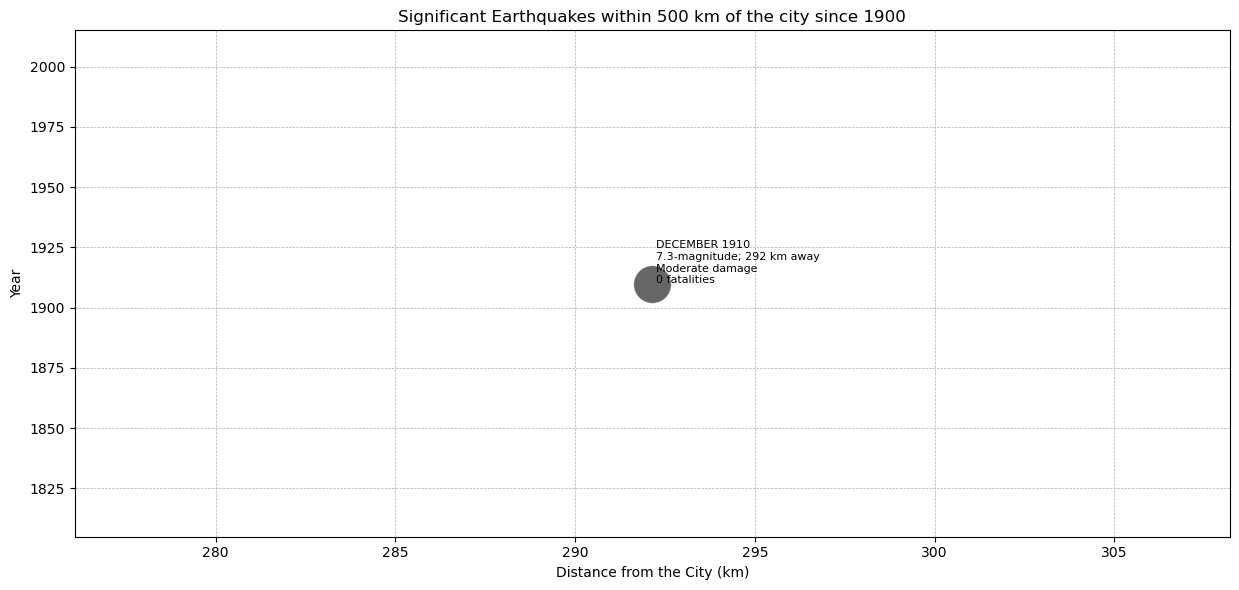

In [28]:
def get_earthquake_data():
    url = "http://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/earthquakes"
    response = requests.get(url, params={"minYear": 1900, "maxYear": datetime.now().year})
    response.raise_for_status()  # Check if the request was successful
    eq_json = response.json()
    eq = pd.json_normalize(eq_json, record_path=['items'])
    return eq
def get_earthquake_timeline():
    damages = {
        "0": "None",
        "1": "Limited",
        "2": "Moderate",
        "3": "Severe",
        "4": "Extreme"
    }

    severity_colors = {
        "Low": "#ff9999",
        "Moderate": "#ff4d4d",
        "High": "#cc0000"
    }

    eq = get_earthquake_data()

    city_point = features.unary_union.centroid

    eq_near = eq.dropna(subset=['latitude', 'longitude'])
    eq_near['geometry'] = eq_near.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    eq_near = gpd.GeoDataFrame(eq_near, geometry='geometry', crs='EPSG:4326')

    eq_near = eq_near.to_crs("EPSG:3857")
    city_point = gpd.GeoSeries([city_point], crs="EPSG:4326").to_crs("EPSG:3857").iloc[0]

    eq_near['distance'] = eq_near.geometry.distance(city_point) / 1000  
    eq_near['magXdist'] = eq_near['eqMagnitude'] * (2000 - eq_near['distance'])

    eq_near['damageAmountOrder'] = eq_near['damageAmountOrder'].fillna(0).astype(int)
    eq_near['damageMillionsDollars'] = eq_near['damageMillionsDollars'].fillna(0).astype(float)
    eq_near['deaths'] = eq_near['deaths'].fillna(0).astype(int)
    eq_near['deathsAmountOrder'] = eq_near['deathsAmountOrder'].fillna(0).astype(int)
    eq_near['eqMagnitude'] = eq_near['eqMagnitude'].fillna(0).astype(float)
    eq_near['intensity'] = eq_near['intensity'].fillna(0).astype(int)

    conditions = (
        (eq_near['damageAmountOrder'] >= 2) |
        (eq_near['damageMillionsDollars'] >= 1) |
        (eq_near['deaths'] >= 10) |
        (eq_near['deathsAmountOrder'] >= 2) |
        (eq_near['eqMagnitude'] >= 7.5) |
        (eq_near['intensity'] >= 10) |
        (~eq_near['tsunamiEventId'].isna())
    )

    eq_near = eq_near[conditions & (eq_near['distance'] < 500)]

    eq_text = eq_near.copy()
    if 'locationName' in eq_text.columns:
        eq_text['locationName'] = eq_text['locationName'].astype(str)
        eq_text['location'] = eq_text['locationName'].str.extract(r"([^:][\s]+.*)", expand=False).str.strip()
    else:
        eq_text['location'] = ""

    eq_text['fatalities'] = eq_text['deaths'].apply(lambda x: f"{int(x):,} fatalities" if pd.notna(x) else "")
    eq_text['fatalities'] = eq_text['fatalities'].str.replace("1 fatalities", "1 fatality")
    eq_text['fatalities'] = eq_text['fatalities'].str.replace("NA fatalities", "")
    eq_text['damage'] = eq_text['damageAmountOrder'].apply(lambda x: damages.get(str(int(x)), "Unknown") + " damage")
    eq_text['day'] = eq_text['day'].fillna(1).astype(int)
    eq_text['BEGAN'] = pd.to_datetime(eq_text[['year', 'month', 'day']])

    eq_text = eq_text.sort_values(by='BEGAN')
    eq_text['line1'] = eq_text['BEGAN'].dt.strftime('%B %Y').str.upper()
    eq_text['line2'] = eq_text.apply(lambda row: f"{row['eqMagnitude']}-magnitude; {int(row['distance']):,} km away", axis=1)
    eq_text['line3'] = eq_text['damage']
    eq_text['line4'] = eq_text['fatalities']
    eq_text['text'] = eq_text.apply(lambda row: f"{row['line1']}\n{row['line2']}\n{row['line3']}\n{row['line4']}", axis=1)
    eq_text['above_line'] = (2 * (np.arange(len(eq_text)) % 2) - 1) * -1

    eq_text_select = eq_text.nlargest(10, 'magXdist').sort_values(by='BEGAN')

    eq_text_select['severity_color'] = eq_text_select['damageAmountOrder'].apply(lambda x: severity_colors.get(str(int(x)), 'black'))

    plt.figure(figsize=(12.5, 6))
    scatter = plt.scatter(eq_text_select['distance'], eq_text_select['BEGAN'].dt.year, s=eq_text_select['eqMagnitude'] * 100, alpha=0.6, c=eq_text_select['severity_color'], edgecolors="w", linewidth=0.5)
    for _, row in eq_text_select.iterrows():
        plt.text(row['distance'] + 0.1, row['BEGAN'].year + 0.1, row['text'], fontsize=8, ha='left')
    plt.xlabel('Distance from the City (km)')
    plt.ylabel('Year')
    plt.title('Significant Earthquakes within 500 km of the city since 1900')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    render_path = os.path.join(render_folder, f"{city}_earthquake_timeline.png")
    plt.savefig(render_path, bbox_inches='tight')
    plt.show()

    fig = go.Figure()

    fig.add_trace(go.Scatter(
    x=eq_text_select['distance'],
    y=eq_text_select['BEGAN'].dt.year,
    marker=dict(
        size=eq_text_select['eqMagnitude'] * 10,
        color=eq_text_select['damageAmountOrder'],
        colorscale=['#ff9999', '#ff4d4d', '#cc0000'],
        showscale=True
    ),
    text=eq_text_select['text'],  
    hoverinfo='text', 
    textposition='top center'
    ))

    fig.update_layout(
        template='plotly_white',
        xaxis=dict(
            title='Distance from the City (km)',
            linecolor='black', 
            titlefont=font_dict
        ),
        autosize=True,
        yaxis=dict(
            title='',
            tickmode='linear',  
            dtick=1,
            linecolor='black',
            titlefont=font_dict
        ),
        font=font_dict,
        showlegend=False,
        plot_bgcolor='white'  
    )
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'), full_html=False, include_plotlyjs='cdn')



In [25]:
#flood timeline
def flood_timeline():
    with open("../global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    city_inputs = global_inputs.get('city_inputs')

    if menu['flood']:  
        flood_archive_path = global_inputs.get('flood_timeline_source')
        flood_archive = gpd.read_file(flood_archive_path)
        flood_archive = flood_archive[flood_archive.is_valid]
        aoi = features.to_crs(flood_archive.crs)
        flood_archive = flood_archive[flood_archive.intersects(aoi.unary_union)]

        floods = flood_archive[['BEGAN', 'ENDED', 'DEAD', 'DISPLACED', 'MAINCAUSE', 'SEVERITY']]

        print("Tally of flood events")
        print(floods.agg({'DEAD': 'sum', 'DISPLACED': 'sum', 'BEGAN': 'count'}))

        floods['BEGAN'] = pd.to_datetime(floods['BEGAN'])
        floods['Year'] = floods['BEGAN'].dt.year
        floods['Month'] = floods['BEGAN'].dt.month_name()

        severity_mapping = {
            1: 'Large event',
            1.5: 'Very large event',
            2: 'Extreme event'
        }
        floods['Severity'] = floods['SEVERITY'].map(severity_mapping)
        floods['text'] = floods.apply(
            lambda row: f"{row['BEGAN'].strftime('%Y-%m-%d')}, {row['Severity'].lower()} {row['MAINCAUSE']}, "
                        f"{row['DEAD']:,} fatalities, {row['DISPLACED']:,} displaced",
            axis=1
        )

        os.makedirs(render_folder, exist_ok=True)

        floods['Month'] = pd.Categorical(floods['Month'], 
                                        categories=['January', 'February', 'March', 'April', 'May', 'June', 
                                                    'July', 'August', 'September', 'October', 'November', 'December'], 
                                        ordered=True)

        fig = px.scatter(
            floods,
            x='Year',
            y='Month',
            size='DISPLACED',
            color='Severity',
            size_max=60,
            category_orders={'Month': ['January', 'February', 'March', 'April', 'May', 'June', 
                                    'July', 'August', 'September', 'October', 'November', 'December']},
            color_discrete_map={
                'Large event': 'lightblue',
                'Very large event': 'blue',
                'Extreme event': 'darkblue'
            },
            labels={'DEAD': 'Fatalities', 'Year': 'Year', 'DISPLACED': 'Displaced', 'Month': 'Month'}
        )

        fig.update_layout(
            template='plotly_white',
            autosize=True,
            xaxis_title='',
            yaxis_title='',
            xaxis=dict(
                linecolor='black'  
            ),       
            yaxis=dict(
                type='category', 
                categoryorder='array', 
                categoryarray=['January', 'February', 'March', 'April', 'May', 'June', 
                            'July', 'August', 'September', 'October', 'November', 'December'],
                tickvals=['January', 'February', 'March', 'April', 'May', 'June', 
                        'July', 'August', 'September', 'October', 'November', 'December'],
                linecolor='black'
            ),
            coloraxis_colorbar=dict(title='Severity'),
            font=font_dict,
            showlegend=False,
            plot_bgcolor='white'  
        )

        render_path_html = os.path.join(render_folder, f"{city}_flood_timeline.html")
        fig.write_html(render_path_html, full_html=False, include_plotlyjs='cdn')
        fig.show()

        plt.figure(figsize=(12.5, 6))
        colors = {
            'Large event': 'lightblue',
            'Very large event': 'blue',
            'Extreme event': 'darkblue'
        }
        month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                       'July', 'August', 'September', 'October', 'November', 'December']
        for severity, color in colors.items():
            subset = floods[floods['Severity'] == severity]
            plt.scatter(subset['Year'], subset['Month'].map(lambda x: month_order.index(x) + 1), 
                        s=subset['DISPLACED']/10000, c=color, label=severity, alpha=0.6, edgecolors='w', linewidth=0.5)
        
        plt.yticks(ticks=range(1, 13), labels=month_order)
        plt.title('Flood Events Timeline')
        plt.xlabel('Year')
        plt.ylabel('Month')
        plt.legend(title='Severity')
        plt.grid(True)
        render_path_matplotlib = os.path.join(render_folder, f"{city}_flood_timeline.png")
        plt.savefig(render_path_matplotlib)
        plt.close()


In [29]:
def extract_monthly_stats():
    
    with open("../global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pv_directory = global_inputs.get('solar_graph_source')

    
    pv_files = [f for f in os.listdir(pv_directory) if f.endswith('.tif')]

    
    monthly_pv = []

    aoi = aoi_file.geometry

    for f in pv_files:
        pattern = re.compile(r'PVOUT_(\d{2})')
        match = pattern.search(f)
        if match:
            m = int(match.group(1))  

            file_path = os.path.join(pv_directory, f)

            with rasterio.open(file_path) as src:
                
                raster_data, raster_transform = mask(src, aoi.geometry, crop=True)

                stats = {
                    'month': m,
                    'max': np.nanmax(raster_data),
                    'min': np.nanmin(raster_data),
                    'mean': np.nanmean(raster_data),
                    'sum': np.nansum(raster_data)
                }

                
                monthly_pv.append(stats)
        else:
            print(f"No match found for filename: {f}")

    monthly_pv_df = pd.DataFrame(monthly_pv)

    monthly_pv_df.sort_values(by='month', inplace=True)
    

    monthly_pv_df['daily'] = monthly_pv_df['max']/30

    
    highest_value = monthly_pv_df['daily'].max()
    lowest_value = monthly_pv_df['daily'].min()

    
    ratio = highest_value / lowest_value

    # Check if the ratio is greater than 2.5
    if ratio > 2.5:
        print("Seasonality is high, making solar energy available throughout the year")
    else:
        print("Seasonality is low to moderate, making solar energy available in only some of the months")


    plt.figure(figsize=(8, 8))
    plt.plot(monthly_pv_df['month'], monthly_pv_df['daily'], marker='o', linestyle='-')


    plt.axhline(y=3.5, linestyle='--', color='black')
    plt.text(1, 3.52, 'Favorable Conditions', color='darkgrey', verticalalignment='bottom', horizontalalignment='left')

    plt.axhline(y=4.5, linestyle='--', color='black')
    plt.text(1, 4.52, 'Excellent Conditions', color='darkgrey', verticalalignment='bottom', horizontalalignment='left')

    plt.xlabel('Month')
    plt.ylabel('Daily PV energy yield (kWh/kWp)')
    plt.title('Seasonal availability of solar energy')
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.tight_layout()

    render_path = os.path.join(render_folder, f"{city}_PV_graph.png")
    plt.savefig(render_path, bbox_inches='tight')
    plt.close()

    fig = px.line(monthly_pv_df, x='month', y='daily', markers=True)
    fig.add_annotation(x=6.5,y=4.6, text='Excellent Conditions', showarrow=False, font=dict(color='darkgrey'),xanchor='center', xref='x')
    fig.add_annotation(x=6.5,y=3.6, text='Favorable Conditions', showarrow=False, font=dict(color='darkgrey'),xanchor='center', xref='x')
    fig.update_xaxes(title='', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    fig.update_yaxes(title='Daily PV energy yield (kWh/kWp)', range=[0, None])
    fig.add_shape(type="line", x0=1, y0=3.5, x1=12, y1=3.5, line=dict(color="black", width=1, dash='dash'))
    fig.add_shape(type="line", x0=1, y0=4.5, x1=12, y1=4.5, line=dict(color="black", width=1, dash='dash'))
    fig.update_traces(line=dict(color='black'))
    fig.update_layout(xaxis=dict(showgrid=True, zeroline=False,linecolor='black'),yaxis=dict(linecolor='black'),template='plotly_white',autosize=True,font=font_dict,plot_bgcolor='white')
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'),full_html=False, include_plotlyjs='cdn')
